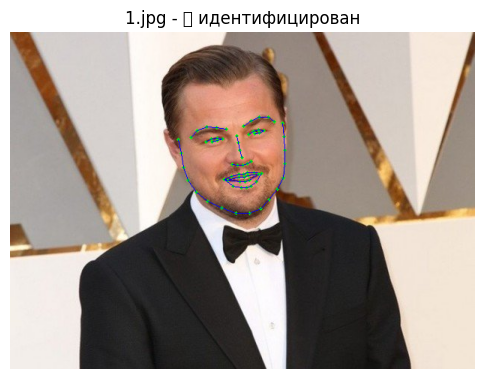

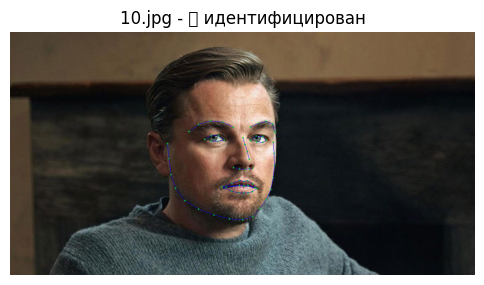

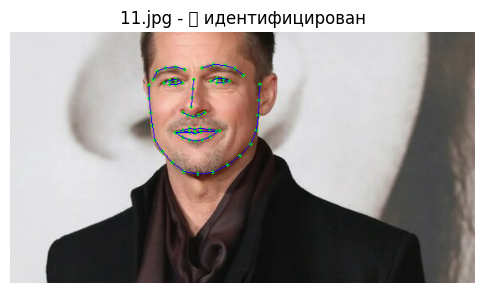

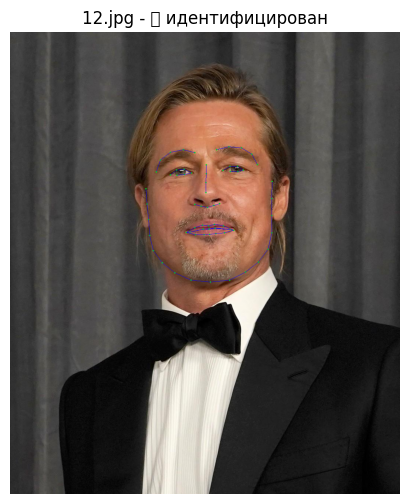

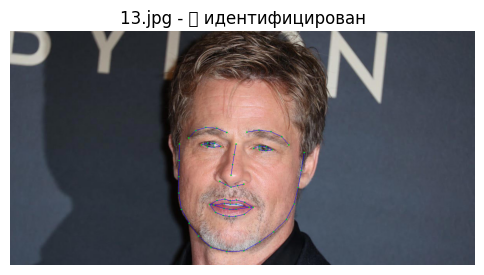

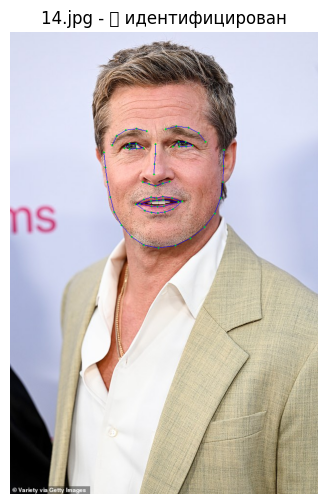

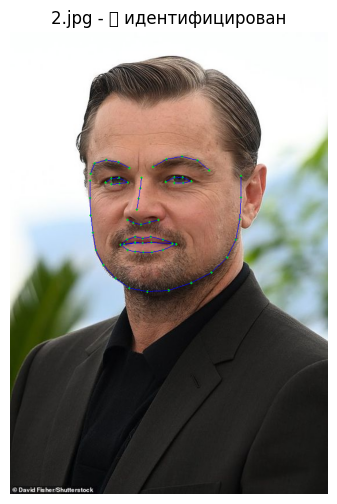

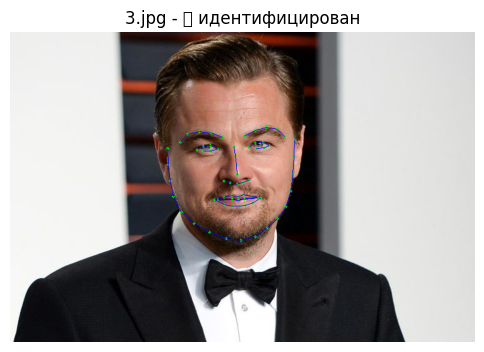

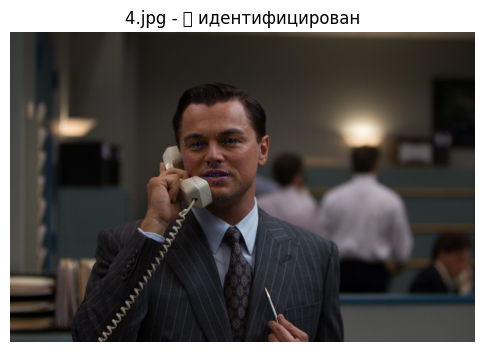

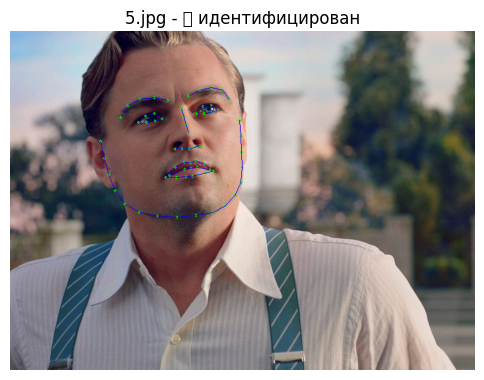

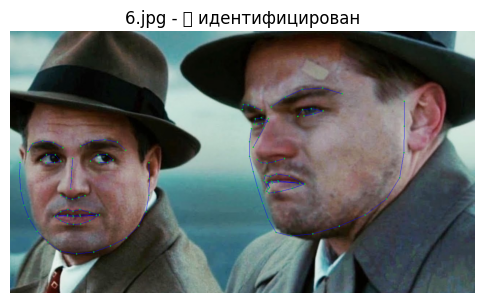

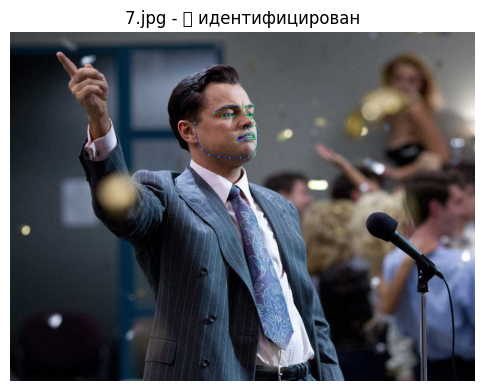

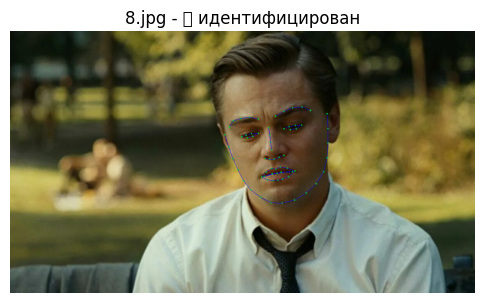

[9.jpg] лицо не найдено

=== РЕЗУЛЬТАТЫ ===
Идентифицированы: ['1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
Не идентифицированы: ['9.jpg']


In [8]:
import os
import cv2
import face_recognition
from deepface import DeepFace
import numpy as np
import matplotlib.pyplot as plt

# --- Эталонное изображение ---
reference_path = "1.jpg"

# --- Папка с фотографиями ---
folder_path = "./"
threshold_cosine = 0.6
threshold_arcface = 0.7
threshold_avg = 0.65

# --- Загрузка эталона ---
ref_img = face_recognition.load_image_file(reference_path)
ref_enc = face_recognition.face_encodings(ref_img)[0]

identified, not_identified = [], []

for filename in os.listdir(folder_path):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    test_path = os.path.join(folder_path, filename)
    test_img = face_recognition.load_image_file(test_path)
    test_encs = face_recognition.face_encodings(test_img)

    if len(test_encs) == 0:
        print(f"[{filename}] лицо не найдено")
        not_identified.append(filename)
        continue

    test_enc = test_encs[0]
    cosine_dist = 1 - np.dot(ref_enc, test_enc) / (np.linalg.norm(ref_enc) * np.linalg.norm(test_enc))

    arcface_result = DeepFace.verify(reference_path, test_path, model_name="ArcFace", enforce_detection=False)
    arcface_dist = arcface_result["distance"]
    arcface_verified = arcface_result["verified"]

    avg_dist = (cosine_dist + arcface_dist) / 2.0
    ensemble_verified = avg_dist < threshold_avg
    majority_verified = (cosine_dist < threshold_cosine and arcface_verified)

    if ensemble_verified or majority_verified:
        status = "✅ идентифицирован"
        identified.append(filename)
    else:
        status = "❌ не идентифицирован"
        not_identified.append(filename)

    # --- Визуализация сетки ---
    img_cv = cv2.imread(test_path)
    face_landmarks_list = face_recognition.face_landmarks(test_img)

    for landmarks in face_landmarks_list:
        for feature, points in landmarks.items():
            for (x, y) in points:
                cv2.circle(img_cv, (x, y), 2, (0, 255, 0), -1)
            cv2.polylines(img_cv, [np.array(points)], isClosed=False, color=(255, 0, 0), thickness=1)

    # --- Вывод в Jupyter ---
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(f"{filename} - {status}")
    plt.axis("off")
    plt.show()

# --- Итог ---
print("\n=== РЕЗУЛЬТАТЫ ===")
print("Идентифицированы:", identified)
print("Не идентифицированы:", not_identified)


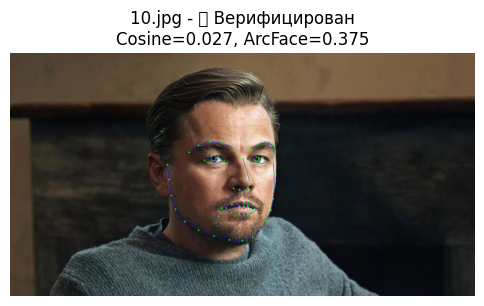

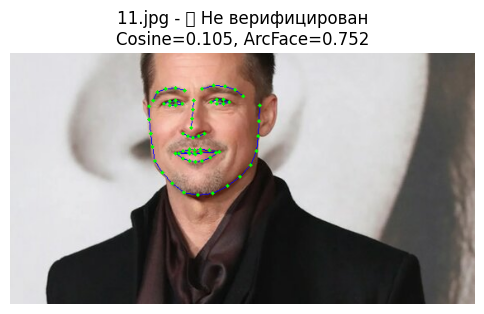

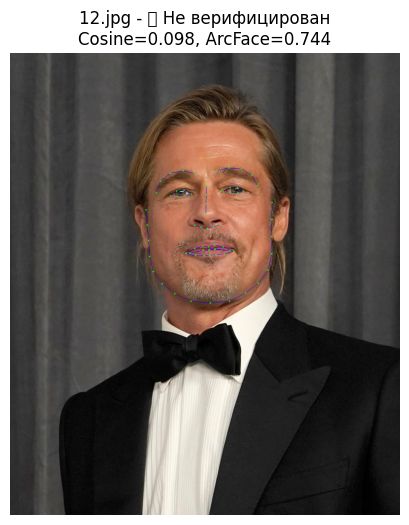

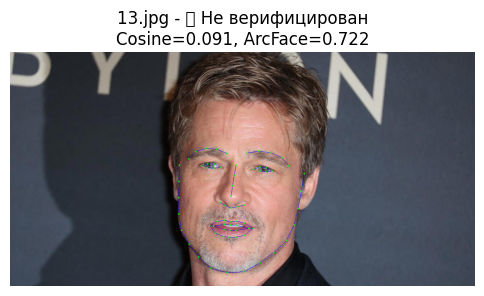

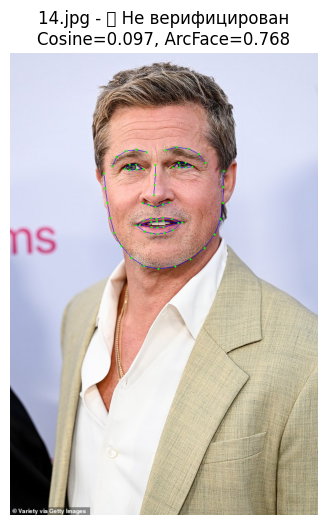

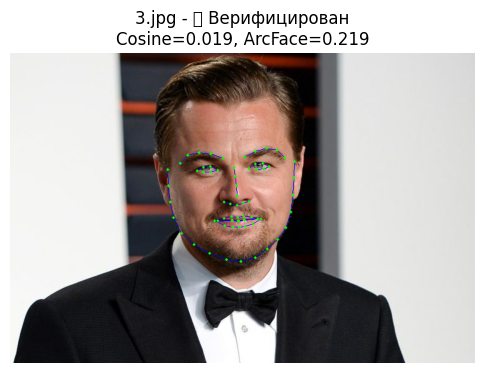

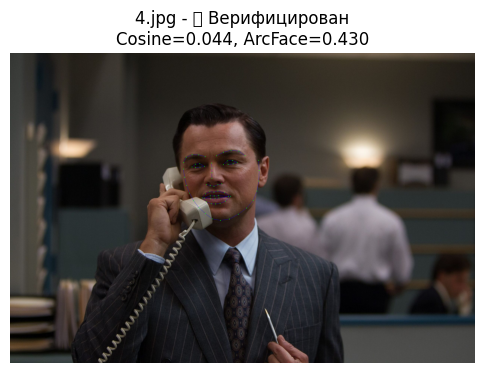

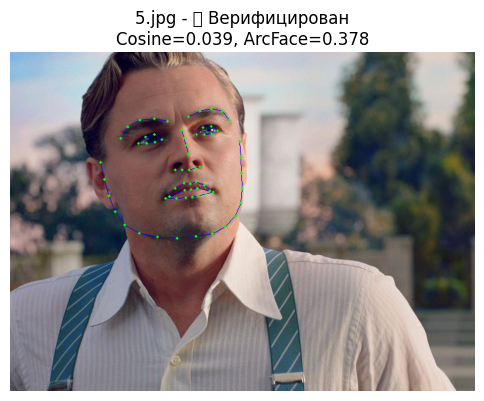

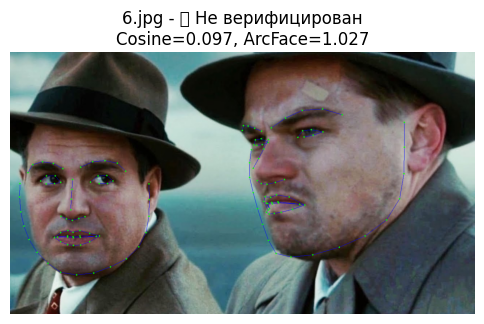

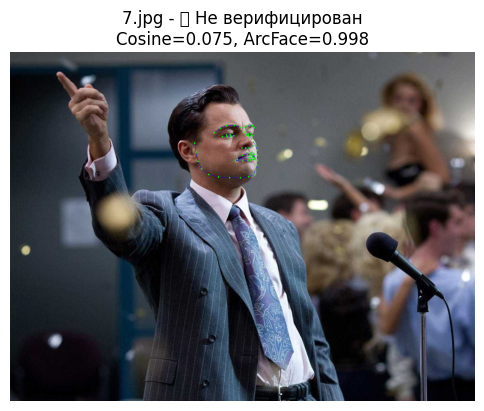

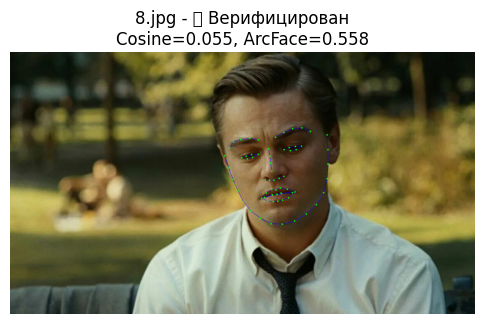

[9.jpg] лицо не найдено

=== РЕЗУЛЬТАТЫ ВЕРИФИКАЦИИ ===
Верифицированы: ['10.jpg', '3.jpg', '4.jpg', '5.jpg', '8.jpg']
Не верифицированы: ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '6.jpg', '7.jpg', '9.jpg']
Все результаты сохранены в verification_results.csv


In [15]:
import os
import cv2
import face_recognition
from deepface import DeepFace
import numpy as np
import matplotlib.pyplot as plt
import csv

# --- Эталонные фото ---
ref_paths = ["1.jpg", "2.jpg"]

# --- Папка с фотографиями ---
folder_path = "./"

# --- Пороги ---
threshold_cosine = 0.6
threshold_arcface = 0.7
threshold_avg = 0.65

# --- Получаем эмбеддинги эталона (Dlib) ---
ref_encs = []
for path in ref_paths:
    img = face_recognition.load_image_file(path)
    encs = face_recognition.face_encodings(img)
    if len(encs) > 0:
        ref_encs.append(encs[0])

verified, not_verified = [], []

# --- CSV для логов ---
csv_file = "verification_results.csv"
with open(csv_file, mode="w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "cosine_dist", "arcface_dist", "status"])

    # --- Перебор всех файлов в папке ---
    for filename in os.listdir(folder_path):
        if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        if filename in ref_paths:
            continue  # эталонные фото не проверяем

        test_path = os.path.join(folder_path, filename)
        test_img = face_recognition.load_image_file(test_path)
        test_encs = face_recognition.face_encodings(test_img)

        if len(test_encs) == 0:
            print(f"[{filename}] лицо не найдено")
            not_verified.append(filename)
            writer.writerow([filename, None, None, "no_face"])
            continue

        test_enc = test_encs[0]

        # --- Сравнение с каждым эталоном ---
        cosine_dists, arcface_dists, arcface_flags = [], [], []
        for ref_enc, ref_path in zip(ref_encs, ref_paths):
            cos_dist = 1 - np.dot(ref_enc, test_enc) / (np.linalg.norm(ref_enc) * np.linalg.norm(test_enc))
            cosine_dists.append(cos_dist)

            arcface_result = DeepFace.verify(ref_path, test_path, model_name="ArcFace", enforce_detection=False)
            arcface_dists.append(arcface_result["distance"])
            arcface_flags.append(arcface_result["verified"])

        # Берём минимум по эталонам
        cosine_dist = min(cosine_dists)
        arcface_dist = min(arcface_dists)

        # Новое правило: оба должны пройти порог
        ensemble_verified = (cosine_dist < threshold_cosine) and (arcface_dist < threshold_arcface)

        if ensemble_verified:
            status = "✅ Верифицирован"
            verified.append(filename)
        else:
            status = "❌ Не верифицирован"
            not_verified.append(filename)


        # --- Запись в CSV ---
        writer.writerow([filename, f"{cosine_dist:.4f}", f"{arcface_dist:.4f}", status])

        # --- Визуализация сетки ---
        img_cv = cv2.imread(test_path)
        face_landmarks_list = face_recognition.face_landmarks(test_img)

        for landmarks in face_landmarks_list:
            for feature, points in landmarks.items():
                cv2.polylines(img_cv, [np.array(points)], isClosed=False, color=(255, 0, 0), thickness=1)
                for (x, y) in points:
                    cv2.circle(img_cv, (x, y), 2, (0, 255, 0), -1)

        img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6))
        plt.imshow(img_rgb)
        plt.title(f"{filename} - {status}\nCosine={cosine_dist:.3f}, ArcFace={arcface_dist:.3f}")
        plt.axis("off")
        plt.show()

# --- Итог ---
print("\n=== РЕЗУЛЬТАТЫ ВЕРИФИКАЦИИ ===")
print("Верифицированы:", verified)
print("Не верифицированы:", not_verified)
print(f"Все результаты сохранены в {csv_file}")
